       ## ANALYSIS 4TH CAMPAIGN

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import ROOT
import numpy as np
import os
from array import array

from utils_lib import  wu_rootfile, wu_rootfileList, fromDatafile_fill
from graph_lib import plot_root_param_xy

In [ ]:
RAW_DATA = "/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/RawData/"
ROOT_FILES = "/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/RootFiles/"


FILES = {
    "1MW2": {
        "DEF": [
            {
                "filename": "20250606_1501_1MW2_400nm_350V_reps3_zscan_baseline_substrated",
                "subtype": "zscan",
            },
            {
                "filename": "20250606_1516_1MW2_400nm_450V_reps3_zscan_baseline_substrated",
                "subtype": "zscan",
            },
        ],
    },


}

def rf(file_name):
    return f"{ROOT_FILES}{file_name}.root"

def ls_rootfile(file_name, tree_name="analysis", max_preview=5):
    """
    max_preview:
      - nº máximo de elementos a mostrar si el vector es pequeño
      - si len(vector) > max_preview → solo se imprime el tamaño
    """
    import ROOT

    root_path = rf(file_name)

    f = ROOT.TFile.Open(root_path)
    if not f or f.IsZombie():
        print(f"[ERROR] No se pudo abrir: {root_path}")
        return

    print(f"\n=== Contenido de {root_path} ===")
    f.ls()

    t = f.Get(tree_name)
    if not t:
        print(f"[WARNING] No existe el TTree '{tree_name}'")
        f.Close()
        return

    print(f"\n--- TTree: {tree_name} (estructura) ---")
    t.Print()

    if t.GetEntries() == 0:
        print("[INFO] Tree sin entradas")
        f.Close()
        return

    print(f"\n--- TTree: {tree_name} (valores, entry 0) ---")
    t.GetEntry(0)

    for br in t.GetListOfBranches():
        name = br.GetName()
        val = getattr(t, name)
        cls = val.__class__.__name__

        # ---------- vectores ----------
        if "vector" in cls:
            n = len(val)

            if n == 0:
                print(f"{name} = vector (empty)")
            elif n <= max_preview:
                print(f"{name} = vector[{n}] {list(val)}")
            else:
                print(f"{name} = vector[{n}]")

        # ---------- strings ----------
        elif "string" in cls:
            print(f"{name} = '{str(val)}'")

        # ---------- escalares ----------
        else:
            print(f"{name} = {val}")

    f.Close()



### ANÁLISIS - 1MW2


#### Generate root files 

In [4]:
IMG_Path = RAW_DATA = "/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/1MW2_Images/"


In [11]:
from pathlib import Path

filenames = [entry["filename"] for entry in FILES["1MW2"]["DEF"]]
root_files = [ f"{ROOT_FILES}{file_name}.root" for file_name in filenames]
print("DATAFILES:")
for name in filenames:
    outpath = Path(ROOT_FILES) / f"{name}.root"
    print(filenames)
    _nameList = ["dataPath"]
    _dataList = [f"{RAW_DATA}{name}"]
    wu_rootfile(str(outpath), _nameList, _dataList)  # si quieres inicializar “vacío”
print("DONE!")

DATAFILES:
['20250606_1501_1MW2_400nm_350V_reps3_zscan_baseline_substrated', '20250606_1516_1MW2_400nm_450V_reps3_zscan_baseline_substrated']
['20250606_1501_1MW2_400nm_350V_reps3_zscan_baseline_substrated', '20250606_1516_1MW2_400nm_450V_reps3_zscan_baseline_substrated']
DONE!


#### Initial fill - WFs + initial parameters



In [6]:
initial_pars = {
  "dt": 0.05,
}

fromDatafile_fill(filenames, ROOT_FILES, RAW_DATA)

# Common mods:
for key, value in initial_pars.items():
  wu_rootfileList(root_files, [key], [value])

In [12]:
for _rp in root_files:
    f = ROOT.TFile.Open(_rp)
    _tree = f.Get("analysis")
    _tree.GetEntry(0)

    # número de samples temporales
    n_samples = int(_tree.WFsRaw_shape1)

    # vectores
    events = np.arange(n_samples, dtype=np.int32)
    t = events.astype(np.float64) * float(_tree.dt)

    f.Close()

    # escribir de vuelta al mismo ROOT
    wu_rootfile(_rp, ["events", "t"], [events, t])

print("DONE!")


DONE!


PNG : /home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/1MW2_Images/t_vs_WFsRaw.png


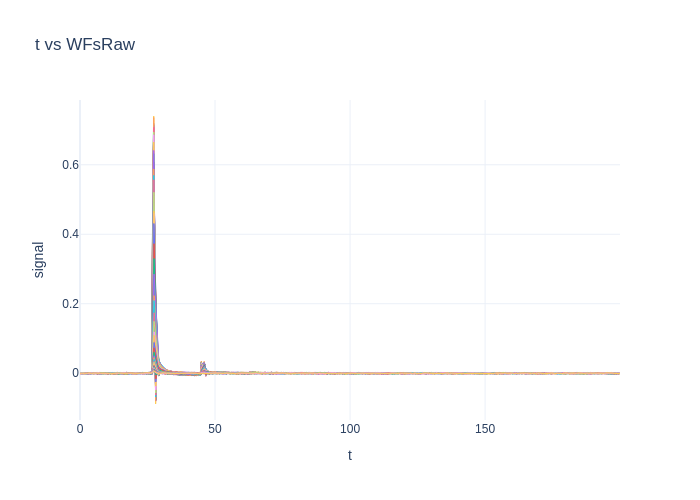

('/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/1MW2_Images/t_vs_WFsRaw.png',
 '/home/cquintana/Software/Docker/TPA_TCT_root/SiC4thCamp/1MW2_Images/t_vs_WFsRaw.html')

In [ ]:
#ls_rootfile(filenames[1])

plot_root_param_xy(
    out_dir=IMG_Path,
    out_name="t_vs_WFsRaw",
    root_files=[root_files[0]],
    x_param="t",
    y_param="WFsRaw",
    labels=["t vs WFsRaw", "t", "signal"],
    show=True,
    style="line",
)

In [ ]:
# Visual analysis of WFs
_nameList = ["aTBL", "aTLeft", "aTRight"]
_dataList = [25, 26.55, 44.0]
wu_rootfileList(root_files, _nameList, _dataList)

In [ ]:
# Calculation of individual BLLevel TLeft and TRight
